In [1]:
from tabu_search.algorithm import tabu_search, NeighborsTabuListInterface, TabuSearchResult
import numpy as np
from typing import Collection, Callable, Any, Tuple, List

REPS = 200
DPI = 150
ERROR_BAR = "sd"

# Part 1

In [2]:
EDGES = 8
COSTS = [13, 7, 9, 1, 3, 19, 10, 7]
EDGE_MAPPING = {
    0: (1, 2),
    1: (1, 3),
    2: (1, 4),
    3: (2, 3),
    4: (3, 4),
    5: (2, 5),
    6: (3, 5),
    7: (4, 5),
}

In [3]:
def mst_cost(edges):
    base_cost = np.dot(COSTS, edges)
    penalty1 = 100 if edges[2] + edges[6] + edges[7] > 1 else 0
    penalty2 = 100 if edges[7] > edges[5] else 0
    return base_cost + penalty1 + penalty2


def cause_cycle(s: List) -> bool:
    visited = set()
    for i in range(len(s)):
        if s[i] > 0:
            visited.add(EDGE_MAPPING[i][0])
            visited.add(EDGE_MAPPING[i][1])
    return len(visited) < 5


class MSTNeighborTabu(NeighborsTabuListInterface):
    def __init__(self, tenure: int, nbrs_size: int, cost: Callable[[Collection], float]):
        super().__init__(tenure, nbrs_size, cost)
        self.tabu_list = []

    def neighbors(self, s_current: List) -> Tuple[Collection, Collection]:
        nbrs = []
        attrs = []

        def try_generate_neighbor():
            # picks an edge, if it's already picked, then i2_candidates are unpicked edges and vice versa
            i1_try = np.random.randint(8)
            i1_flag = s_current[i1_try]
            i2_candidates = [i for i in range(len(s_current)) if s_current[i] != i1_flag]

            # for each candidate, test swapping and checks for cycle
            for i2_candidate in i2_candidates:
                clone = s_current[:]

                # swaps edges
                clone[i1_try] = (clone[i1_try] + 1) % 2
                clone[i2_candidate] = (clone[i2_candidate] + 1) % 2

                # checks for cycle, if no cycle after swap then assign
                if not cause_cycle(clone):
                    return i1_try, i2_candidate

            # if generated candidates did not help, throw everything away
            return None, None

        for _ in range(self.nbrs_size):
            # repeat the above part until assigned
            i1, i2 = try_generate_neighbor()
            while i1 is None and i2 is None:
                i1, i2 = try_generate_neighbor()

            copied = s_current[:]
            copied[i1] = (copied[i1] + 1) % 2
            copied[i2] = (copied[i2] + 1) % 2

            # nbrs => the new neighbor, i1 will always be the inserted edge
            nbrs.append(copied)
            if copied[i1] == 1:
                attrs.append((i1, i2))
            else:
                attrs.append((i2, i1))

        return nbrs, attrs

    def add(self, attr: int, _):
        i1, _ = attr
        if len(self.tabu_list) >= self.tenure:
            self.tabu_list.pop(0)
        self.tabu_list.append(i1)

    def evaluate(self, s_current: Collection, _) -> float:
        return self.cost(s_current)

    def is_tabu(self, attr: Any, _):
        return attr[0] in self.tabu_list


In [4]:
s0 = [1, 1, 1, 0, 0, 1, 0, 0]

res = tabu_search(mst_cost, s0, MSTNeighborTabu(3, 4, mst_cost), 100)
res.cost, res.solution

(21, [0, 1, 0, 1, 1, 0, 1, 0])

In [5]:
len(res.progress_current), len(res.progress_best)

(101, 101)

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

In [7]:
def form_result(results: List[TabuSearchResult], max_iters=100) -> pd.DataFrame:
    dfs = [
        pd.DataFrame({
            "Iteration": np.arange(max_iters + 1),
            "Best progress": result.progress_best,
            "Current progress": result.progress_current,
        }) for result in results
    ]
    combined = pd.concat(dfs).set_index("Iteration")
    combined["Optimal"] = 21
    return combined

<Axes: xlabel='Iteration'>

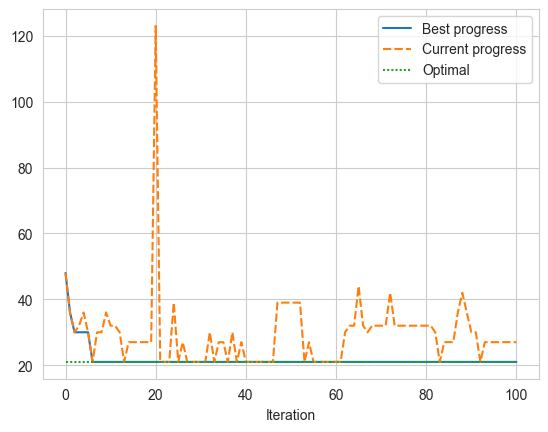

In [8]:
sns.lineplot(form_result([res]))

# Part 2

## Changing $|T|$, everything else is fixed

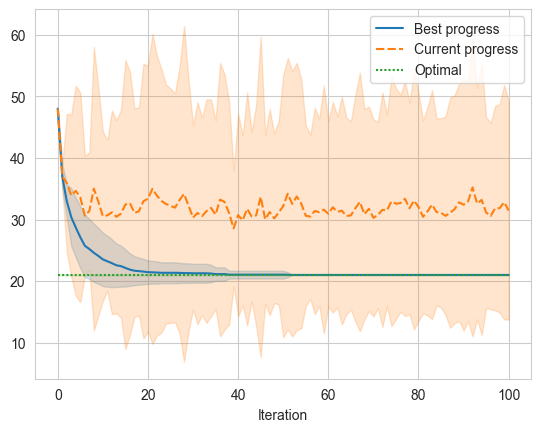

In [9]:
added24s = [tabu_search(mst_cost, s0, MSTNeighborTabu(2, 4, mst_cost), 100) for _ in range(REPS)]
added24s_df = form_result(added24s)
sns.lineplot(added24s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added24s", dpi=DPI, bbox_inches="tight")

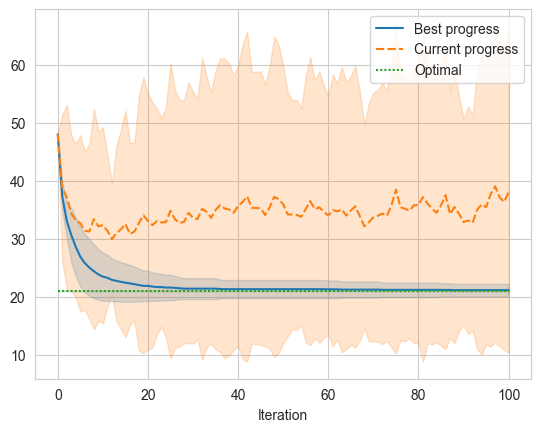

In [10]:
added34s = [tabu_search(mst_cost, s0, MSTNeighborTabu(3, 4, mst_cost), 100) for _ in range(REPS)]
added34s_df = form_result(added34s)
sns.lineplot(added34s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added34s", dpi=DPI, bbox_inches="tight")

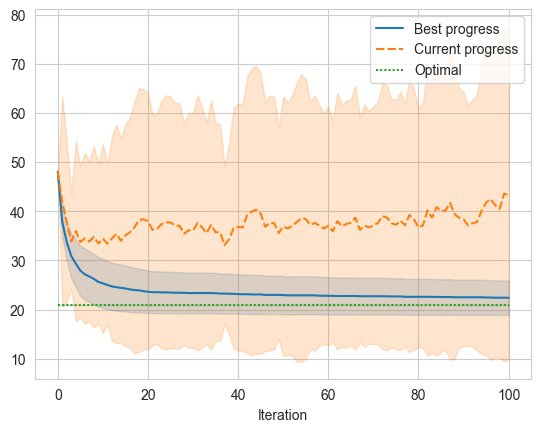

In [11]:
added44s = [tabu_search(mst_cost, s0, MSTNeighborTabu(4, 4, mst_cost), 100) for _ in range(REPS)]
added44s_df = form_result(added44s)
sns.lineplot(added44s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added44s", dpi=DPI, bbox_inches="tight")

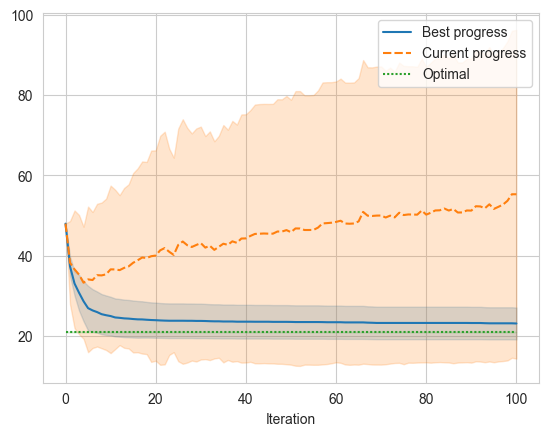

In [12]:
added64s = [tabu_search(mst_cost, s0, MSTNeighborTabu(6, 4, mst_cost), 100) for _ in range(REPS)]
added64s_df = form_result(added64s)
sns.lineplot(added64s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added64s", dpi=DPI, bbox_inches="tight")

## Changing $|V^*|$, everything else is fixed

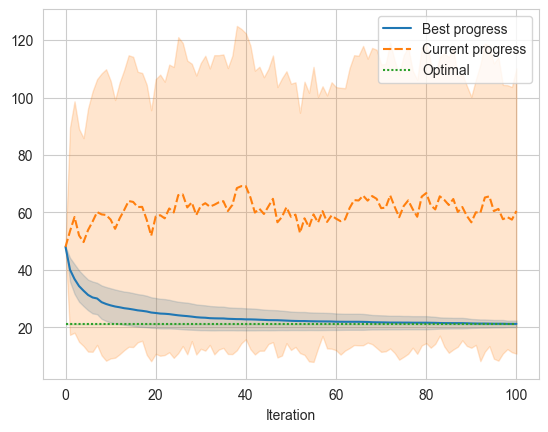

In [13]:
added32s = [tabu_search(mst_cost, s0, MSTNeighborTabu(3, 2, mst_cost), 100) for _ in range(REPS)]
added32s_df = form_result(added32s)
sns.lineplot(added32s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added32s", dpi=DPI, bbox_inches="tight")

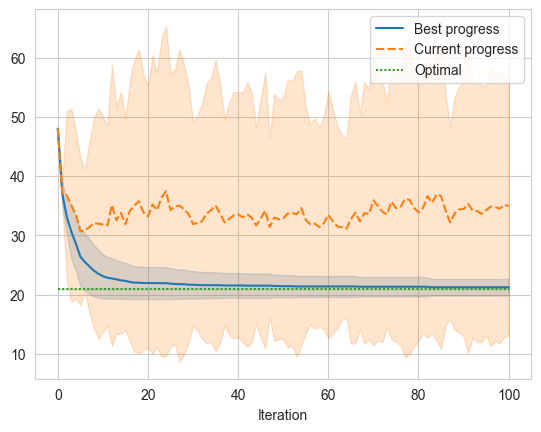

In [14]:
added34s = [tabu_search(mst_cost, s0, MSTNeighborTabu(3, 4, mst_cost), 100) for _ in range(REPS)]
added34s_df = form_result(added34s)
sns.lineplot(added34s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added34s", dpi=DPI, bbox_inches="tight")

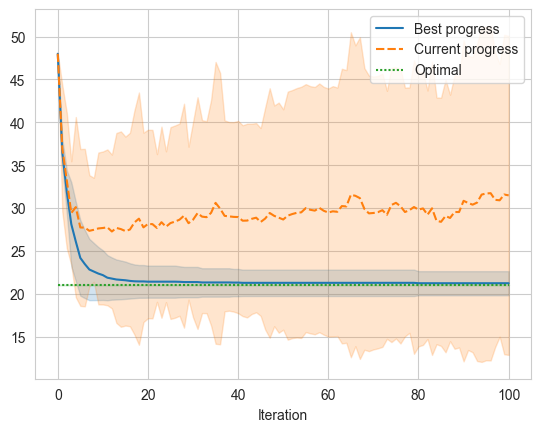

In [15]:
added36s = [tabu_search(mst_cost, s0, MSTNeighborTabu(3, 6, mst_cost), 100) for _ in range(REPS)]
added36s_df = form_result(added36s)
sns.lineplot(added36s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added36s", dpi=DPI, bbox_inches="tight")

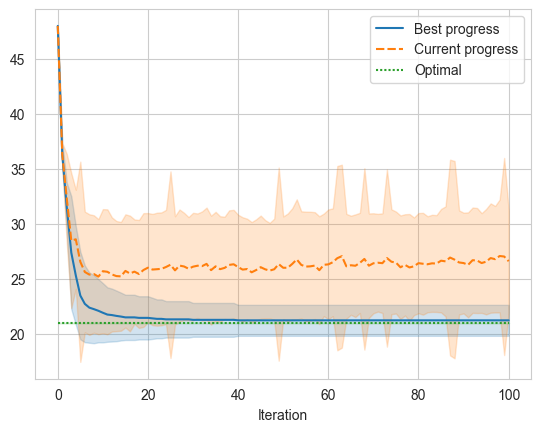

In [16]:
added38s = [tabu_search(mst_cost, s0, MSTNeighborTabu(3, 8, mst_cost), 100) for _ in range(REPS)]
added38s_df = form_result(added38s)
sns.lineplot(added38s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added38s", dpi=DPI, bbox_inches="tight")

## Changing attribute stored, everything else is fixed

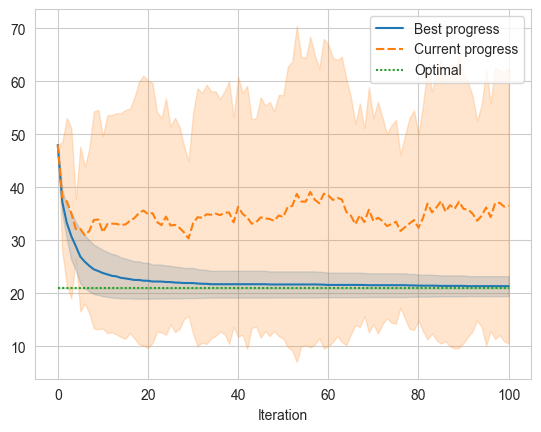

In [17]:
added34s = [tabu_search(mst_cost, s0, MSTNeighborTabu(3, 4, mst_cost), 100) for _ in range(REPS)]
added34s_df = form_result(added34s)
sns.lineplot(added34s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/added34s", dpi=DPI, bbox_inches="tight")

In [18]:
class MSTNeighborTabuDeleted(MSTNeighborTabu):
    def add(self, attr: Any, _):
        _, i2 = attr
        if len(self.tabu_list) >= self.tenure:
            self.tabu_list.pop(0)
        self.tabu_list.append(i2)

    def is_tabu(self, attr: Any, _):
        _, i2 = attr
        return i2 in self.tabu_list

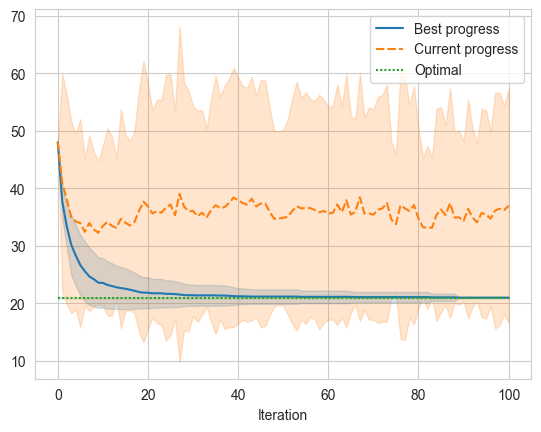

In [19]:
deleted34s = [tabu_search(mst_cost, s0, MSTNeighborTabuDeleted(3, 4, mst_cost), 100) for _ in range(REPS)]
deleted34s_df = form_result(deleted34s)
sns.lineplot(deleted34s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/deleted34s", dpi=DPI, bbox_inches="tight")

In [20]:
class MSTNeighborTabuBoth(MSTNeighborTabu):
    def __init__(self, tenure: int, nbrs_size: int, cost: Callable[[Collection], float]):
        super().__init__(tenure, nbrs_size, cost)
        self.tabu_list = np.zeros((8, 8), dtype=int)

    def add(self, attr: Tuple[int, int], i):
        i1, i2 = sorted(attr)
        self.tabu_list[i1, i2] = i + self.tenure

    def is_tabu(self, attr: Any, i):
        i1, i2 = sorted(attr)
        return self.tabu_list[i1, i2] <= i

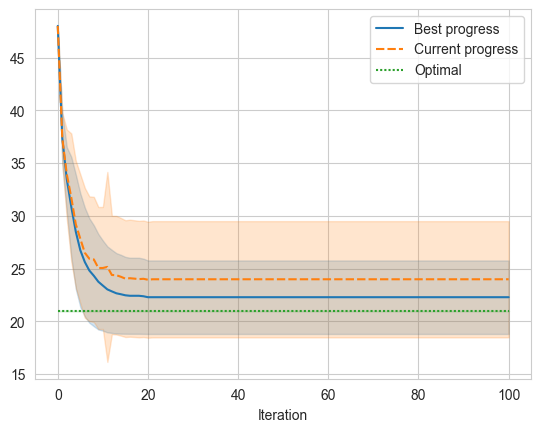

In [21]:
both34s = [tabu_search(mst_cost, s0, MSTNeighborTabuBoth(3, 4, mst_cost), 100) for _ in range(REPS)]
both34s_df = form_result(both34s)
sns.lineplot(both34s_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/both34s", dpi=DPI, bbox_inches="tight")

## What I think is best

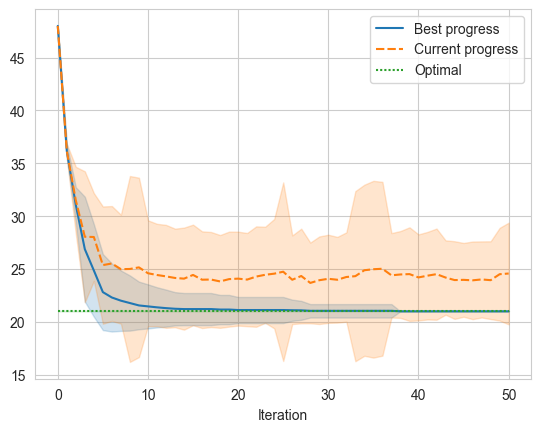

In [22]:
best = [tabu_search(mst_cost, s0, MSTNeighborTabu(2, 8, mst_cost), 50) for _ in range(REPS)]
best_df = form_result(best, 50)
sns.lineplot(best_df, errorbar=ERROR_BAR)
plt.savefig("../../images/p1/best", dpi=DPI, bbox_inches="tight")